# Tutorial on single-cell trajectory alignment using Genes2Genes

Genes2Genes (G2G) aims to guide downstream comparative analysis of single-cell reference and query systems along any axis of progression (e.g. differentiation pseudotime, disease/treatment response pseudotime etc.). This notebook describes how we can use G2G framework to infer and analyse gene-level trajectory alignments between a given reference and query dataset.

In this tutorial, we are going to compare trajectories between two treatment groups (PAM and LPS) of mouse bone marrow-derived dendritic cells from Shalek et al (2014). The single cell datasets and their pseudotime estimates were downloaded from https://github.com/shenorrLab/cellAlign (Alpert et al 2018) and packaged into adata objects. There are 2 gene modules: global (core antiviral module) and local (peaked inflammatory module) considered by Alpert et al (2018), and we use the local module as an example comparison.

In [119]:
import anndata
import numpy as np
import seaborn as sb
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from genes2genes import Main
from genes2genes import ClusterUtils
from genes2genes import TimeSeriesPreprocessor
from genes2genes import PathwayAnalyser
from genes2genes import VisualUtils

### Load anndata reference and query objects

Make sure that each adata object has: <br>
(1) log normalized gene expression in `adata.X` <br>
(2) pseudotime estimates in `adata.obs['time']`

In [120]:
adata_ref = anndata.read_h5ad("Hackathon_line1.h5ad") # Reference dataset
adata_query = anndata.read_h5ad("Hackathon_line2.h5ad") # Query dataset

## 1. Preparing data for alignment 

### Pseudotime range check
Check whether the current range of pseudotime values are between 0 and 1. If not, run min max normalization. 

In [123]:
print(min(adata_ref.obs['time']), max(adata_ref.obs['time']))
print(min(adata_query.obs['time']), max(adata_query.obs['time']))

## uncomment below if the pseudotime range is not [0,1] for any of the objects 
adata_ref.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_ref.obs['time']))
adata_query.obs['time'] = TimeSeriesPreprocessor.Utils.minmax_normalise(np.asarray(adata_query.obs['time']))

1.473158220870462e-09 26.359176128559447
7.605714187928821e-06 36.07442637695888


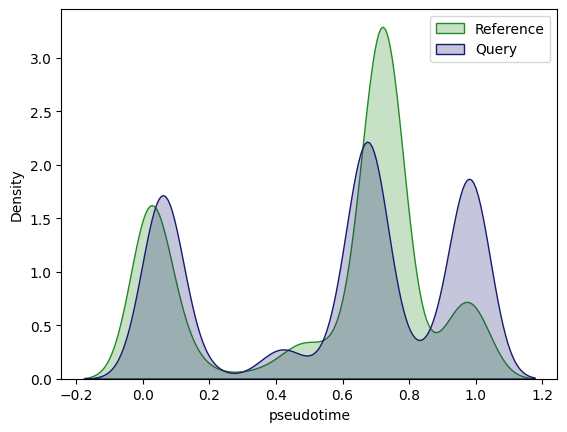

In [124]:
# Visualize the pseudotime distributions
sb.kdeplot(adata_ref.obs['time'], fill=True, label='Reference', color='forestgreen') 
sb.kdeplot(adata_query.obs['time'], fill=True, label='Query', color='midnightblue'); 
plt.xlabel('pseudotime'); plt.legend(); plt.show()

### Determine the number of discrete pseudotime points to align

We can use optbinning package (https://gnpalencia.org/optbinning/installation.html) to get a heuristic estimate about the number of discrete time points to consider by running below on each dataset.<br>  **Note:** Run `pip install optbinning` if this is not already installed. 

In [125]:
from optbinning import ContinuousOptimalBinning

x = np.asarray(adata_ref.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

x = np.asarray(adata_query.obs.time)
optb = ContinuousOptimalBinning(name='pseudotime', dtype="numerical")
optb.fit(x, x)
print(len(optb.splits))

13
14


Accordingly, we go with `n_bins=14`

In [126]:
n_bins = 14

### Define which cell type annotations and color scheme to use for visualization purposes

`annotation_colname` and `joint_cmap`

In [127]:
# define annotation column name in the adata obs
annotation_colname = 'annotation' 
adata_ref.obs[annotation_colname] = [x.split('_')[1] for x in adata_ref.obs_names] 
adata_query.obs[annotation_colname] = [x.split('_')[1] for x in adata_query.obs_names] 

# define the joint colormap to use for both reference and query
col = np.array(sb.color_palette('colorblind'))[range(4)]
joint_cmap={'1h':col[0], '2h':col[1] , '4h':col[2] , '6h':col[3]}

In [130]:
for k in adata_ref.obs_names:
    bc = k.split('_')[1]
    joint_cmap[bc] = "black"

In [131]:
for k in adata_query.obs_names:
    bc = k.split('_')[1]
    joint_cmap[bc] = "black"

Inspect the cell type compositions around each discrete pseudotime point (x-axis) to see if it reasonably represents the entire trajectory of interest. 

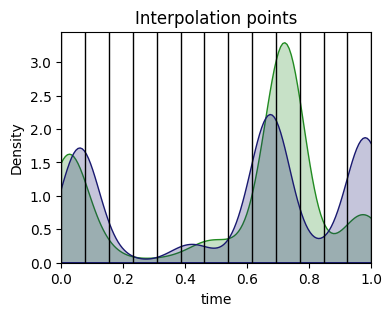

In [132]:
VisualUtils.plot_pseudotime_dists_with_interpolation_points(adata_ref, adata_query, n_bins)

In [ ]:
n_bins = 14
VisualUtils.plot_celltype_barplot(adata_ref, n_bins, annotation_colname, joint_cmap)
VisualUtils.plot_celltype_barplot(adata_query, n_bins, annotation_colname, joint_cmap)

## 2. G2G trajectory alignment

**Example gene sets to align:** all human transcription factors, all highly variable genes, lineage-specific genes of interest, a specific pathway gene set etc.

In [ ]:
# define the gene list to align
gene_list = list(set(adata_ref.var_names) & set(adata_query.var_names))
print(len(gene_list),'genes')

In [ ]:
anndata._core.views.SparseCSCView = anndata._core.views.SparseCSCMatrixView


### Aligning all genes

In [ ]:
aligner = Main.RefQueryAligner(adata_ref, adata_query, gene_list, n_bins) #
aligner.align_all_pairs() 

To access gene-level alignments, use the dictionary: `aligner.results_map` which carries all gene alignment objects. <br>
e.g. `aligner.results_map['TNF']`

In [ ]:
aligner.results_map

In [ ]:
gene_obj = aligner.results_map['SMANTIS']
alignment_str = gene_obj.alignment_str
print(alignment_str)
print(VisualUtils.color_al_str(alignment_str)) 
print()
print(gene_obj.al_visual)
# Alignment landscape of costs (Note: dashed black path is the optimal alignment)
gene_obj.landscape_obj.plot_alignment_landscape()
# Note: optimal path diagonals represent matches; 
# vertical and horizontal paths could represent either warp matches or indels (mismatches)

Visualise alignment in terms of both the cell-type compositions, as well as actual and interpolated gene expression. <br>
Top left: Visualise alignmebt in terms of cell-type composition <br>
Bottom left: the mean trends and interpolated distributions of gene expression along pseudotime. <br>
Bottom right: the actual gene expression values along pseudotime. 

In [ ]:
VisualUtils.plotTimeSeries('SMANTIS', aligner, plot_cells=True)
plt.savefig("traj_smantis.png")

# THIS CELL DOES NOT WORK ATM

MMMMMMIDMMMMMMM
Optimal alignment cost: 9.246 nits
Alignment similarity percentage: 86.67 %


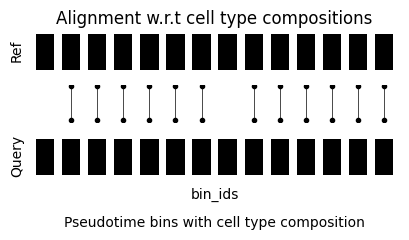

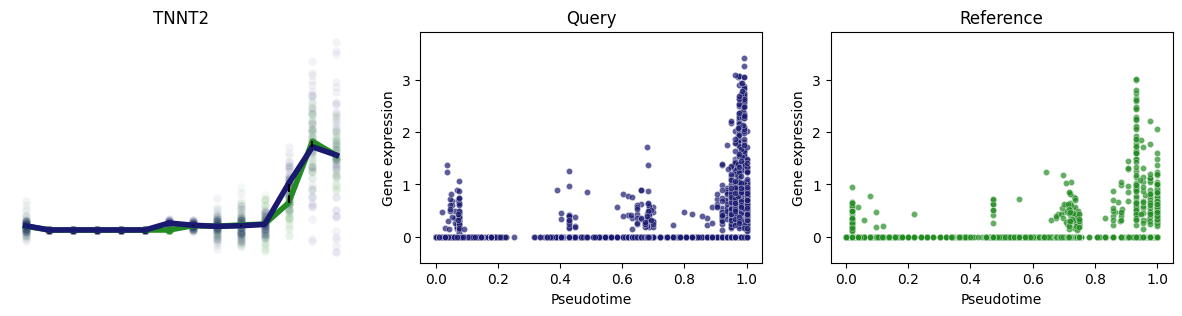

In [75]:
VisualUtils.show_gene_alignment('TNNT2', aligner, adata_ref, adata_query, annotation_colname, joint_cmap)

# Visualise gene-level alignment in terms of only the cell-type composition 
# VisualUtils.visualize_gene_alignment(aligner.results_map['TNF'], adata_ref, adata_query, annotation_colname, cmap=joint_cmap)

### Aggregate (average) cell-level alignment across all aligned genes

This is an average alignment which is sampled based on the frequency distribution of alignment states between each pair of reference and query timepoints. The heatmap value gives the number of genes where the corresponding timepoints have been matched. Note: There can still be different patterns of alignment across these genes (100% mismatching, 100% matching, early mismatching, late mismatching gene groups) which we will find by clustering in the next section. 

Average Alignment:  MMMIIDDMMMMMMMMM (cell-level)
% similarity: 75.0


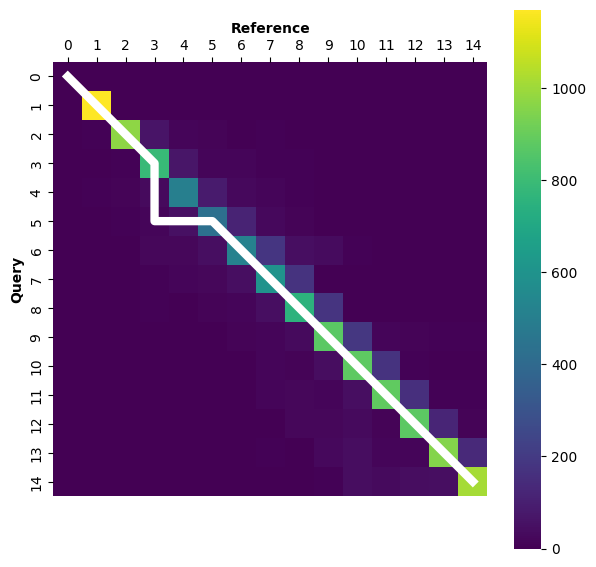

In [117]:
aligner.get_aggregate_alignment() 
# Note: White path represents the average alignment path where diagonals represent matches; 
# vertical and horizontal paths could represent either warp matches or indels (mismatches)
plt.savefig("traj_aggregate.png")

## 3. Analysing gene-level alignments

Ranking genes based on their alignment similarities

Mean alignment similarity percentage (matched %): 
72.72999999999999 %


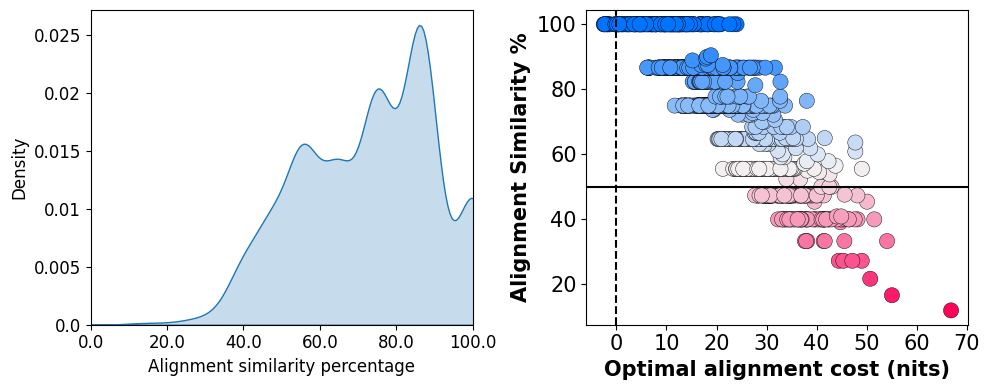

In [118]:
df = aligner.get_stat_df() # ordered genes according to alignment similarity statistics 
df
plt.savefig("traj_stats.png")

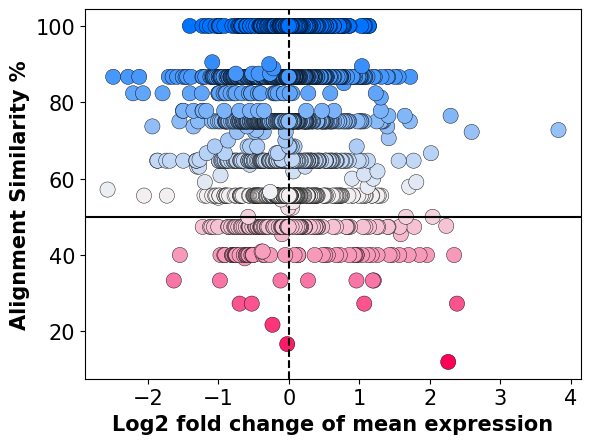

In [78]:
VisualUtils.plot_alignmentSim_vs_l2fc(df)

A ranked list of genes based on their first match occurrence 

In [89]:
earliest_match_sorted_genes_list = aligner.show_ordered_alignments() 

In the order of the first match occurrence along pseudotime
Gene             Alignment
---------------  --------------------------
GNGT1            MMMMMMMMMMMMMM
MRPS26           MMMMMMMMMMMMMM
ABTB2            MMMMMMMMMMMMMM
ENSG00000251654  MMMMMMMMMMMMMM
NECTIN3-AS1      MMMMMMMMMMMMMM
MT1H             MMMMMMMMMMMMMM
KCNIP1           MMMMMMMMMMMMMM
MSX1             MMMMMMMMMMMMMM
CSMD3            MMMMMMMMMMMMMM
LINC01331        MMMMMMMMMMMMMM
ENSG00000287749  MMMMMMMMMMMMMM
ATF5             MMMMMMMMMMMMMM
ALDH1A2          MMMMMMMMMMMMMM
DPH6-DT          MMMMMMMMMMMMMM
HSPA6            MMMMMMMMMMMMMM
FHOD3            MMMMMMMMMMMMMM
MIR122HG         MMMMMMMMMMMMMM
CADPS            MMMMMMMMMMMMMM
ENSG00000259754  MMMMMMMMMMMMMM
SULT1E1          MMMMMMMMMWWWWWIIIII
EGFLAM           MMMMMMMMMMMMMM
ENSG00000285708  MMMMMMMMMMMMMM
AGTR1            MMMMMMMMMMMMMM
ENSG00000255910  MMMMMMMMMMMMMM
ENSG00000285939  MMMMMMMMMMMMMM
ENSG00000254987  MMMMMMMMMMMMMM
ENSG00000254951  MMMMMMMMMMMMMM


## Gene-set overrepresentation analysis on the top dissimilar genes 

Checking top dissimilar genes, i.e, only <=30% similarity along pseudotime

In [99]:
threshold_similarity = 0.3 
topDEgenes = df[list(df['alignment_similarity_percentage'] <=threshold_similarity)]['Gene']
# Calling wrapper function for GSEAPy enrichr inferface
pathway_df = PathwayAnalyser.run_overrepresentation_analysis(topDEgenes) 
pathway_df.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,-log10 Adjusted P-value,-log10 FDR q-val
1,KEGG_2021_Human,Cell adhesion molecules,2/148,0.001115,0.005574,0,0,54.375342,369.705972,CDH5;CD34,2.253862,2.253862
2,KEGG_2021_Human,Salivary secretion,1/93,0.032104,0.047654,0,0,36.052536,123.976563,CST1,1.321900,1.321900
3,KEGG_2021_Human,Hematopoietic cell lineage,1/99,0.034145,0.047654,0,0,33.835034,114.266093,CD34,1.321900,1.321900
4,KEGG_2021_Human,Leukocyte transendothelial migration,1/114,0.039230,0.047654,0,0,29.321534,94.952524,CDH5,1.321900,1.321900
5,KEGG_2021_Human,Fluid shear stress and atherosclerosis,1/139,0.047654,0.047654,0,0,23.979469,72.988394,CDH5,1.321900,1.321900


## Clustering alignments 

Running experiment to determine the distance threshold for alignment clusters from hierarchical clustering. We aim to select a locally optimal threshold that gives a good trade-off between high mean Silhouette score and low number of clusters which can be biologically meaningful. 

In [102]:
df = ClusterUtils.run_clustering(aligner, metric='levenshtein', experiment_mode=True) 

Compute distance matrix
- using levenshtein distance metric
Experimental mode: exploring different thresholds


  0%|          | 0/99 [00:00<?, ?it/s]


TypeError: AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

Run clustering with the chosen distance threshold. In this case we select 0.37

In [21]:
ClusterUtils.run_clustering(aligner, metric='levenshtein', DIST_THRESHOLD=0.37) 

Compute distance matrix
- using levenshtein distance metric
run agglomerative clustering | distance threshold = 0.37
silhouette_score:  0.3757459494624326


Visualise gene alignment grouped together in each cluster <br>
Note: diagonals represent matches; vertical and horizontal paths could represent either warp matches or indels (mismatches)

Cluster ID | Number of genes in the cluster


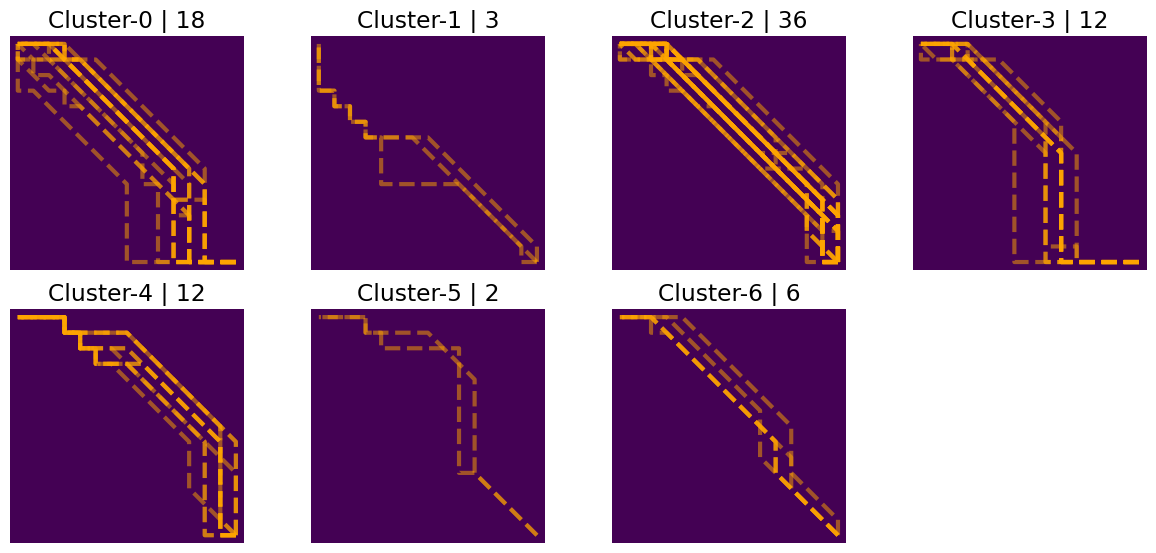

In [22]:
ClusterUtils.visualise_clusters(aligner,n_cols = 4, figsize= (10,6))

Visualise the distance matrix used in the clustering 

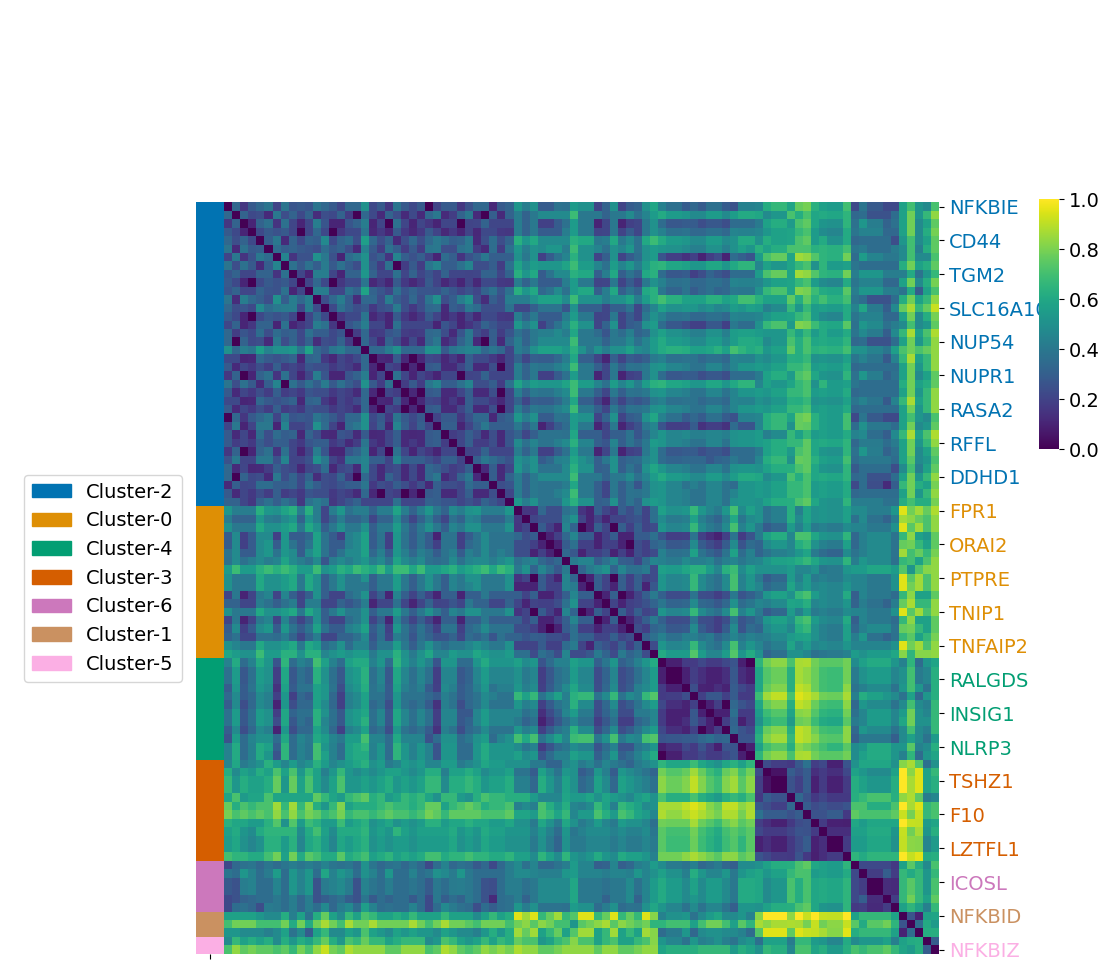

In [23]:
VisualUtils.plot_distmap_with_clusters(aligner)

Print the aggregate (average) cell-level alignments for each cluster

In [24]:
ClusterUtils.print_cluster_average_alignments(aligner)

cluster:  0 IDDDMMMMMMMIIDIIIIDDD ( 18 genes)
cluster:  1 IIIDIDIDIDIDDDMMMMMMM ( 3 genes)
cluster:  2 IDDDMMMMMMMMMMIIDI ( 36 genes)
cluster:  3 IDDDMMMMMIMVVVVVIDDDDD ( 12 genes)
cluster:  4 IIIDDDDDDDMMMMMMIIIIID ( 12 genes)
cluster:  5 IIIDIDIDDDDDDMMMMVMVVM ( 2 genes)
cluster:  6 DDMMMMMMMMIIMMMM ( 6 genes)


In [25]:
# To access the genes in a particular cluster
cluster_id = 0
print(aligner.gene_clusters[cluster_id]) 

# To print all gene alignments in the cluster
aligner.show_cluster_alignment_strings(cluster_id)

['FPR1', 'TREM1', 'TOP1', 'CXCL1', 'ORAI2', 'PILRA', 'CLEC4D', 'C5AR1', 'PTPRE', 'LDLR', 'PLSCR1', 'LCP2', 'TNIP1', 'ADORA2B', 'KLF7', 'CPD', 'TNFAIP2', 'SPATA13']
DMMMMMMMMMIIDIIIDDD
DDMMMMMMMMMIDIIIIDD
DDMMMMMMMMIIIIIIDDDD
DDDIDDMMMMMMMIIIIIIDD
DDDIDMMMMMMMIIIIIIDDD
DDIDMMMMMMMIIIIIIDDDD
IMMDIDMMMMMMMIIIDDD
IIIDMMMMMMIIIIIDDDDDDD
DDMMMMMMMMIIIIIIDDDD
DDMMMMMMMMIIDIIIIDDD
DDDIDMMMMMMMMIIIIIDD
DDDMMMMMMMMMIIIIIDD
DDMMMMMMMMIIIIIIDDDD
DDDIDMMMMMMMMIIIIIDD
DDDIDMMMMMMMIIIIIIDDD
IDIDMMMMMMMMMIIIDDD
MDDMMMMMMMIIDIIIIDDD
IDDMMMMMMIIDIIIIIDDDDD


In [26]:
# To get the cluster id of an alignment object, e.g. TNF, 
aligner.results_map['TNF'].cluster_id

4

### Average alignment of any given subset of genes 
e.g. `gene_list[40:60]` or a specific gene set in a specific pathway, e.g. EMT

Average Alignment:  IDDDMMMMMMMIIDIIIIDDD (cell-level)


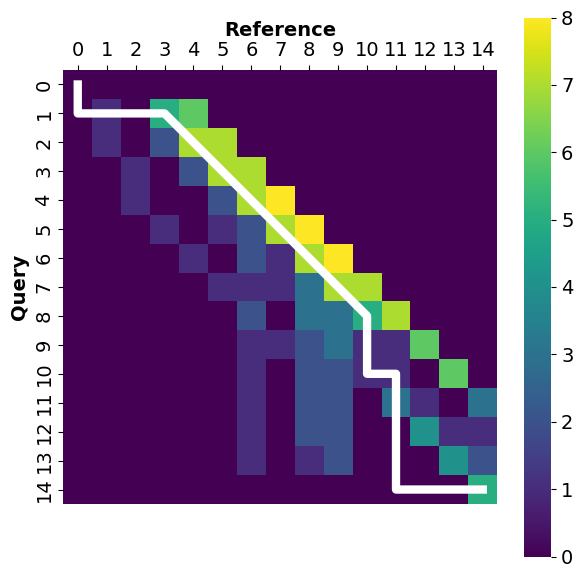

In [27]:
GENE_SUBSET = gene_list[40:60]
aligner.get_aggregate_alignment_for_subset(GENE_SUBSET)

###  Exploring alignment and trends of a given gene set

Following calls a wrapper to extract a specified pathway gene set from msigdb database via blitzgsea package (https://github.com/MaayanLab/blitzgsea) 

In [28]:
IGS = PathwayAnalyser.InterestingGeneSets(gene_list) 
#IGS.get_available_pathway_list('KEGG_2021_Human')
#IGS.get_available_pathway_list('MSigDB_Hallmark_2020')

Initialising to use KEGG_2021_Human and MSigDB_Hallmark_2020 only


You could also add a new library by calling below. <br>

In [30]:
# ===== Check available libraries in enrichr

#import blitzgsea
#blitzgsea.enrichr.print_libraries()

# ===== Add a selected library

#library_name = "GO_Molecular_Function_2021"
#IGS.add_library(blitzgsea.enrichr.get_library(library_name), library_name)

#### Check the aggregate alignment and interpolated gene expression trends for a given pathway gene set as below. 

In [29]:
IGS.add_new_set_from_msigdb('MSigDB_Hallmark_2020', 'Epithelial Mesenchymal Transition', user_setname='EMT') 

Gene set: =======  EMT
mean matched percentage:  51.04 %
Average Alignment:  IDDDMMMMMMMMMMIMI (cell-level)
- Plotting average alignment path
- Plotting z-normalised interpolated mean trends


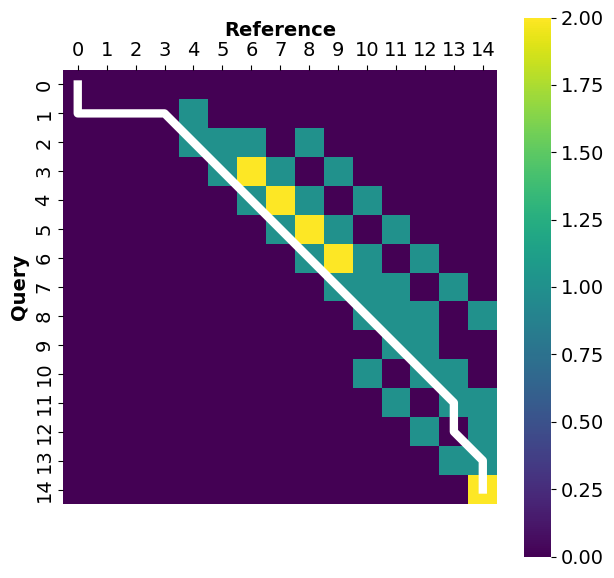

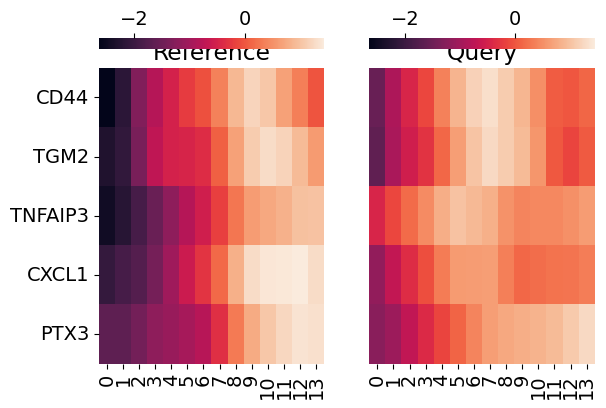

In [30]:
PathwayAnalyser.get_pathway_alignment_stat(aligner, IGS.SETS['EMT'], 'EMT', cluster=True, FIGSIZE=(3,6))

Gene set: =======  EMT
mean matched percentage:  51.29 %
Average Alignment:  IIDDDDMMMMMMMMMIVID (cell-level)
- Plotting average alignment path
- Plotting z-normalised interpolated mean trends


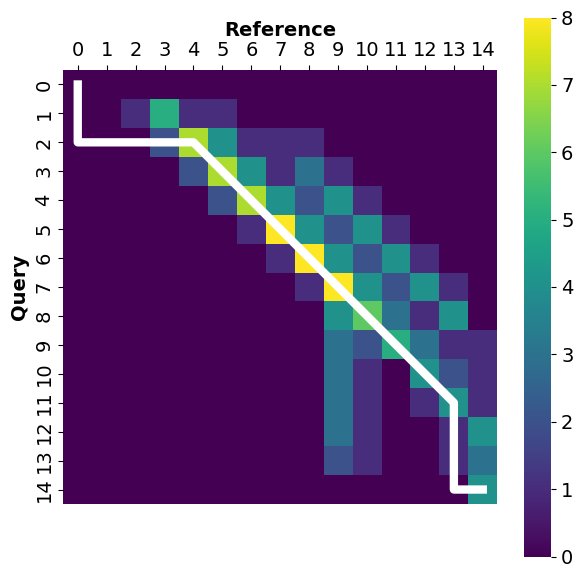

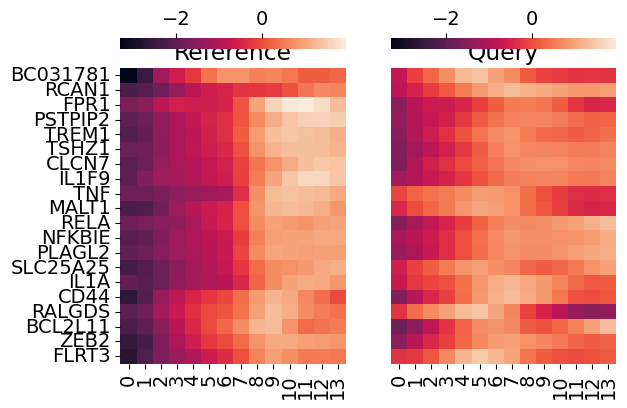

In [31]:
PathwayAnalyser.get_pathway_alignment_stat(aligner, gene_list[0:20], 'EMT', cluster=True, FIGSIZE=(3,6))